In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
cwd = os.getcwd()
cwd

'/Users/michelle/MIDS/210 Capstone'

# Read in files

In [5]:
# read in CSVs
nei2002 = pd.read_csv('cal_nei_2002_b.csv', low_memory=False)
nei2005 = pd.read_csv('cal_nei_2005_b.csv', low_memory=False)
nei2008 = pd.read_csv('cal_nei_2008_b.csv', low_memory=False)
nei2011 = pd.read_csv('cal_nei_2011_b.csv', low_memory=False)
nei2014 = pd.read_csv('cal_nei_2014_b.csv', low_memory=False)
nei2017 = pd.read_csv('cal_nei_2017_b.csv', low_memory=False)

# display all columns in pandas
pd.set_option('display.max_columns', None)

df_list = [nei2002, nei2005, nei2008, nei2011, nei2014, nei2017]

# name DFs
nei2002.name = 'nei2002'
nei2005.name = 'nei2005'
nei2008.name = 'nei2008'
nei2011.name = 'nei2011'
nei2014.name = 'nei2014'
nei2017.name = 'nei2017'

In [6]:
def subset_data(dataset, zip_code_col, lat_col, lon_col, threshold):
    
    
    subset_dict_emission_type_strs = {'nei2002': 'Pollutant_Code_Desc',
                             'nei2005': 'POLLUTANT_CODE',
                             'nei2008': 'description',
                             'nei2011': 'description',
                             'nei2014': 'pollutant_desc',
                             'nei2017': 'pollutant_desc', 
                            }
    
    subset_dict_pm25_strs = {'nei2002': 'Primary PM2.5 (Includes Filterables + Condensibles)',
                             'nei2005': ('PM25-FIL', 'PM25-PRI', 'PM-CON'),
                             'nei2008': 'PM2.5 Primary (Filt + Cond)',
                             'nei2011': 'PM2.5 Primary (Filt + Cond)',
                             'nei2014': 'PM2.5 Primary (Filt + Cond)',
                             'nei2017': 'PM2.5 Primary (Filt + Cond)'
                            }
    subset_dict_emissions_strs = {'nei2002': 'Emissions_TPY',
                             'nei2005': 'ANNUAL_EMISSIONS',
                             'nei2008': 'total_emissions_tons',
                             'nei2011': 'total_emissions_tons',
                             'nei2014': 'total_emissions_tons',
                             'nei2017': 'total_emissions_tons'
                            }
    subset_dict_site_ID_strs = {'nei2002': 'NEISiteID',
                             'nei2005': 'NTI_SITE_ID',
                             'nei2008': 'eis_facility_site_id',
                             'nei2011': 'eis_facility_site_id',
                             'nei2014': 'eis_facility_site_id',
                             'nei2017': 'eis_facility_id'
                            }
    dataset = dataset
    zip_code_col = zip_code_col
    lat_col = lat_col
    lon_col = lon_col
    emission_type_col = subset_dict_emission_type_strs[dataset.name]
    pm25_str = subset_dict_pm25_strs[dataset.name]
    emissions_tons_col = subset_dict_emissions_strs[dataset.name]
    ID_col = subset_dict_site_ID_strs[dataset.name]
    report_year_col = 'report_year'
    
    threshold = threshold
    if threshold >= 1:
        pct_threshold = threshold
        threshold = (100-threshold)/100
    elif threshold < 1:
        threshold = 1-threshold
        pct_threshold = (threshold)*100
        
    try:
        selected_cols = dataset[[emission_type_col, emissions_tons_col, zip_code_col, lat_col, lon_col, report_year_col]] #didn't use ID_col
    except KeyError:
        dataset['report_year'] = dataset.name[-4:]
        selected_cols = dataset[[emission_type_col, emissions_tons_col, zip_code_col, lat_col, lon_col, report_year_col]]
        
    selected_cols.sort_values(emissions_tons_col, ascending=True)
    if dataset.name == 'nei2005':
        filtered_pm25 = selected_cols[(selected_cols[emission_type_col] == pm25_str[0]) |
                                      (selected_cols[emission_type_col] == pm25_str[1]) |
                                      (selected_cols[emission_type_col] == pm25_str[2])]
    else:
        filtered_pm25 = selected_cols[selected_cols[emission_type_col] == pm25_str]
    sorted_emissions = filtered_pm25.groupby([lat_col, lon_col, zip_code_col, report_year_col]).sum().sort_values(by=emissions_tons_col, ascending=True)
    print("All PM 2.5 Emissions: \n {}\n\n".format(sorted_emissions.shape[0]))
    
    # if there's a threshold
    threshold_cutoff = sum(sorted_emissions[emissions_tons_col])*threshold
    threshold_idx = sorted_emissions[emissions_tons_col].cumsum().searchsorted(threshold_cutoff)
    sorted_emissions_threshold = sorted_emissions.iloc[threshold_idx:]
    quantiles = sorted_emissions_threshold[emissions_tons_col].quantile([.1, .25, .5, .75, .85, .9, .95, .97, .99])
    print("Top {}% of PM 2.5 Emissions: \n {}\n\n".format((1-threshold)*100, sorted_emissions_threshold.shape[0]))
    sorted_emissions_threshold.hist(column=emissions_tons_col, bins=20, log=True)
    print("\nQuantiles:\n{}".format(quantiles))
    
    # write csv
    str_pct_threshold = str(pct_threshold)
    csv_name = dataset.name + '_top_' + str_pct_threshold + 'pct_subset.csv'
    #sorted_emissions_threshold.to_csv(csv_name)
    
    return sorted_emissions_threshold



All PM 2.5 Emissions: 
 4957


Top 95.0% of PM 2.5 Emissions: 
 918



Quantiles:
0.10      2.216302
0.25      3.046974
0.50      5.602466
0.75     14.011366
0.85     27.988884
0.90     43.315886
0.95     80.802680
0.97    104.605666
0.99    237.275238
Name: Emissions_TPY, dtype: float64


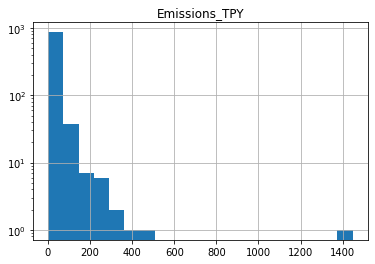

In [7]:
nei2002_subset = subset_data(nei2002, 'zip_code', 'checked_lat', 'checked_lon', 95)

All PM 2.5 Emissions: 
 9030


Top 95.0% of PM 2.5 Emissions: 
 1122



Quantiles:
0.10      2.089190
0.25      2.800099
0.50      4.957114
0.75     12.230757
0.85     22.589888
0.90     37.239539
0.95     80.763140
0.97    129.636916
0.99    275.286704
Name: ANNUAL_EMISSIONS, dtype: float64


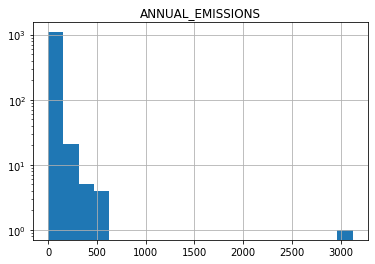

In [8]:
nei2005_subset = subset_data(nei2005, 'zip_code', 'checked_lat', 'checked_lon', 95)

All PM 2.5 Emissions: 
 10822


Top 95.0% of PM 2.5 Emissions: 
 1137



Quantiles:
0.10      1.803963
0.25      2.378963
0.50      4.075550
0.75      9.822665
0.85     18.387921
0.90     30.508300
0.95     66.966288
0.97    116.906963
0.99    278.983337
Name: total_emissions_tons, dtype: float64


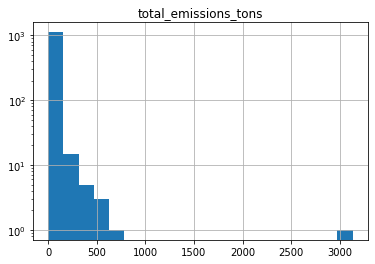

In [9]:
nei2008_subset = subset_data(nei2008, 'zip_code', 'checked_lat', 'checked_lon', 95)

All PM 2.5 Emissions: 
 11940


Top 95.0% of PM 2.5 Emissions: 
 1323



Quantiles:
0.10      1.389241
0.25      1.823415
0.50      3.140000
0.75      7.566396
0.85     13.975161
0.90     22.382305
0.95     46.732699
0.97     73.654351
0.99    207.415104
Name: total_emissions_tons, dtype: float64


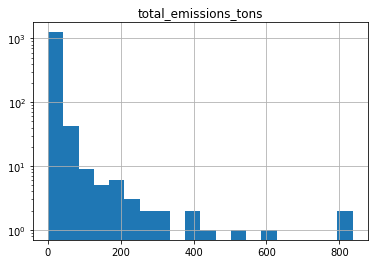

In [10]:
nei2011_subset = subset_data(nei2011, 'zip_code', 'checked_lat', 'checked_lon', 95)

All PM 2.5 Emissions: 
 13238


Top 95.0% of PM 2.5 Emissions: 
 1189



Quantiles:
0.10      1.400631
0.25      1.887280
0.50      3.262810
0.75      7.609207
0.85     13.823728
0.90     21.723010
0.95     39.599268
0.97     83.909140
0.99    246.200177
Name: total_emissions_tons, dtype: float64


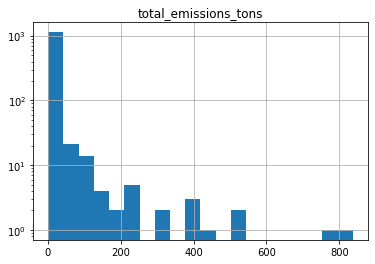

In [12]:
nei2014_subset = subset_data(nei2014, 'zip_code', 'checked_lat', 'checked_lon', 95)



All PM 2.5 Emissions: 
 14657


Top 95.0% of PM 2.5 Emissions: 
 1466



Quantiles:
0.10      0.986259
0.25      1.340208
0.50      2.366512
0.75      5.522902
0.85      9.821495
0.90     14.310957
0.95     29.868929
0.97     54.333953
0.99    127.587689
Name: total_emissions_tons, dtype: float64


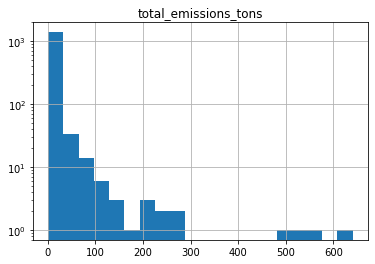

In [13]:
nei2017_subset = subset_data(nei2017, 'zip_code', 'checked_lat', 'checked_lon', 95)

In [14]:
# Standardize titles

df_subset_list = [nei2002_subset, nei2005_subset, nei2008_subset, nei2011_subset, nei2014_subset, nei2017_subset]

for i in df_subset_list:
    i.rename(columns={'Emissions_TPY': 'PM25_emissions_TPY',
                   'ANNUAL_EMISSIONS': 'PM25_emissions_TPY',
                   'total_emissions_tons': 'PM25_emissions_TPY'
                  }, inplace=True
            )

In [98]:
nei2002_subset

,,,,PM25_emissions_TPY
checked_lat,checked_lon,zip_code,report_year,
33.811466,-117.915550,92803.0,2002,1.787854
34.088242,-117.470116,92335.0,2002,1.789200
33.911602,-118.281799,93420.0,2002,1.791300
37.944618,-121.325859,95203.0,2002,1.797500
39.221817,-121.054955,95945.0,2002,1.801540
...,...,...,...,...
38.025414,-122.113251,94553.0,2002,307.379504
34.603149,-117.338593,92368.0,2002,312.212247
38.370838,-120.808243,95654.0,2002,413.799008


In [99]:
nei2005_subset

,,,,PM25_emissions_TPY
checked_lat,checked_lon,zip_code,report_year,
34.077440,-117.499914,92335.0,2005,1.704828
36.047500,-118.937395,93257.0,2005,1.704921
34.150453,-117.400296,92377.0,2005,1.705248
37.032165,-120.202327,93637.0,2005,1.710383
33.710403,-116.203318,92201.0,2005,1.725047
...,...,...,...,...
34.562923,-118.033987,93552.0,2005,477.377417
38.370239,-120.803421,95654.0,2005,496.823835
34.357883,-116.856232,92356.0,2005,504.937101


In [100]:
nei2008_subset

,,,,PM25_emissions_TPY
checked_lat,checked_lon,zip_code,report_year,
32.797000,-115.646000,92243,2008,1.527860
33.774140,-116.968520,92583,2008,1.534657
34.189600,-119.166020,93030,2008,1.537600
34.227270,-118.382290,91352,2008,1.540700
36.677660,-119.752690,93725,2008,1.540854
...,...,...,...,...
34.566396,-117.994191,93552,2008,488.354638
34.604500,-117.338200,92368,2008,582.730058
34.354500,-116.853200,92356,2008,622.355861


In [101]:
nei2011_subset

,,,,PM25_emissions_TPY
checked_lat,checked_lon,zip_code,report_year,
33.619160,-114.716880,0,2011,1.161023
33.867235,-118.257363,90747,2011,1.161820
38.468370,-122.722690,95403,2011,1.161931
32.781540,-116.888540,92019,2011,1.163224
38.694320,-121.747760,95776,2011,1.163970
...,...,...,...,...
34.354500,-116.853200,92356,2011,421.459265
34.567400,-117.993100,93552,2011,507.813288
37.938779,-122.396453,94802,2011,590.108463


In [102]:
nei2014_subset

,,,,PM25_emissions_TPY
checked_lat,checked_lon,zip_code,report_year,
38.376800,-120.793910,0,2014,1.177475
34.113981,-117.984697,91706,2014,1.180108
38.017730,-121.856220,94565,2014,1.181507
35.419205,-118.926540,93308,2014,1.181557
37.642100,-122.135900,94545,2014,1.181899
...,...,...,...,...
37.938779,-122.396453,94802,2014,430.160158
34.567400,-117.993100,93552,2014,507.831621
38.016594,-122.115392,94553,2014,537.715214


In [103]:
nei2017_subset

,,,,PM25_emissions_TPY
checked_lat,checked_lon,zip_code,report_year,
33.359400,-117.111400,92059.0,2017,0.784458
37.493617,-121.935869,0.0,2017,0.784750
32.821000,-117.144000,92123.0,2017,0.785131
38.734600,-121.954430,95695.0,2017,0.786000
35.352150,-119.240640,93312.0,2017,0.790105
...,...,...,...,...
38.025100,-122.063900,94553.0,2017,265.824083
34.622200,-117.100100,92307.0,2017,494.738668
34.231230,-116.056220,92778.0,2017,534.734811


In [118]:
concat_dataset = pd.concat([nei2002_subset, nei2005_subset, nei2008_subset, nei2011_subset, nei2014_subset, nei2017_subset], axis=0)
concat_dataset

,,,,PM25_emissions_TPY
checked_lat,checked_lon,zip_code,report_year,
33.811466,-117.915550,92803.0,2002,1.787854
34.088242,-117.470116,92335.0,2002,1.789200
33.911602,-118.281799,93420.0,2002,1.791300
37.944618,-121.325859,95203.0,2002,1.797500
39.221817,-121.054955,95945.0,2002,1.801540
...,...,...,...,...
38.025100,-122.063900,94553.0,2017,265.824083
34.622200,-117.100100,92307.0,2017,494.738668
34.231230,-116.056220,92778.0,2017,534.734811


In [ ]:
concat_dataset

# Fixing zip codes
Use geopy to get as many zip codes as possible that are missing

In [3]:
import pandas as pd
combined = pd.read_csv('pollution_point_sources.csv', low_memory=False)

In [6]:
# Source: https://gis.stackexchange.com/questions/352961/convert-lat-lon-to-zip-postal-code-using-python

import geopy

def lat_to_zip(lat, lon):
    geolocator = geopy.Nominatim(user_agent="check_2")
    location = geolocator.reverse((lat,lon))
    try:
        return location.raw['address']['postcode']
    except:
        return 0

combined['new_zip'] = combined.apply(lambda row: lat_to_zip(row['checked_lat'], row['checked_lon']), axis = 1)

#combined['new_zip'] = combined.apply(lambda row: row['zip_code'] if row['zip_code'] > 1 else lat_to_zip(row['checked_lat'], row['checked_lon']), axis = 1
#z['c'] = z.apply(lambda row: 0 if row['b'] in (0,1) else row['a'] / math.log(row['b']), axis=1)

In [27]:
# pollution_point_sources.csv - 'zip code column has priority'
combined['combo_zip'] = np.where(combined['zip_code'] > 0, combined['zip_code'], combined['new_zip'])

In [42]:
# pollution_point_sources2.csv - 'new_zip' column has priority
def truncate(zipcode):
    zipcode = str(zipcode)
    if len(zipcode) > 5:
        zipcode = zipcode[:5]
    return int(zipcode)


combined['new_zip'] = combined['new_zip'].apply(truncate)
combined['new_zip'] = pd.to_numeric(combined['new_zip'])
combined['combo_zip'] = np.where(combined['new_zip'] > 0, combined['new_zip'], combined['zip_code'])


In [33]:
combined.dtypes

checked_lat           float64
checked_lon           float64
zip_code              float64
report_year             int64
PM25_emissions_TPY    float64
new_zip                object
combo_zip              object
dtype: object

In [6]:

combined_emissions_missing = combined[combined['combo_zip'] == 0].sort_values(by=["PM25_emissions_TPY"], ascending=False)

In [7]:
combined_emissions_missing.head(20)

,Unnamed: 0,checked_lat,checked_lon,zip_code,report_year,PM25_emissions_TPY,new_zip,combo_zip
4477,4477,35.354129,-119.660220,0.0,2011,137.627459,0,0.0
3145,3145,35.354129,-119.660220,0.0,2008,123.554106,0,0.0
7138,7138,36.034883,-117.798598,0.0,2017,112.671874,0,0.0
5663,5663,36.034883,-117.798598,0.0,2014,112.671865,0,0.0
5662,5662,35.354129,-119.660220,0.0,2014,103.236741,0,0.0
7131,7131,35.354129,-119.660220,0.0,2017,87.892991,0,0.0
5651,5651,36.154253,-120.403320,0.0,2014,83.028941,0,0.0
3132,3132,36.154253,-120.403320,0.0,2008,82.976276,0,0.0
4465,4465,36.154253,-120.403320,0.0,2011,82.090793,0,0.0
7126,7126,35.377482,-119.688445,0.0,2017,80.225257,0,0.0


In [44]:
# new_zip col has priority
combined[combined['combo_zip'] == 0]#

,checked_lat,checked_lon,zip_code,report_year,PM25_emissions_TPY,new_zip,combo_zip
83,34.735500,-120.045502,0.0,2002,2.176343,0,0.0
431,34.691002,-120.037003,0.0,2002,5.198830,0,0.0
2119,35.023550,-119.303630,0.0,2008,1.731463,0,0.0
2169,35.018892,-119.171230,0.0,2008,1.829127,0,0.0
2348,37.105600,-120.248700,0.0,2008,2.469778,0,0.0
...,...,...,...,...,...,...,...
7070,35.025288,-119.286670,0.0,2017,24.785985,0,0.0
7122,36.154253,-120.403320,0.0,2017,69.160609,0,0.0
7126,35.377482,-119.688445,0.0,2017,80.225257,0,0.0
7131,35.354129,-119.660220,0.0,2017,87.892991,0,0.0


In [45]:
combined.to_csv('pollution_point_sources2.csv')

In [14]:
combined.iloc[83]

checked_lat              34.7355
checked_lon          -120.045502
zip_code                     0.0
report_year                 2002
PM25_emissions_TPY      2.176343
new_zip                        0
Name: 83, dtype: object

In [11]:
combined.dtypes

checked_lat           float64
checked_lon           float64
zip_code              float64
report_year             int64
PM25_emissions_TPY    float64
new_zip                object
dtype: object

# Testing

In [43]:

geolocator = geopy.Nominatim(user_agent="check_1")

def lat_to_zip(lat, lon):
    geolocator = geopy.Nominatim(user_agent="check_1")
    location = geolocator.reverse((lat,lon))
    try:
        return location.raw['address']['postcode']
    except:
        return 0

In [9]:
df = pd.DataFrame({
    'Lat': [29.39291, 29.39923, 29.40147, 29.38752, 29.39291, 29.39537, 29.39343, 29.39291, 29.39556, 37.99576],
    'Lon': [-98.50925, -98.51256, -98.51123, -98.52372, -98.50925, -98.50402, -98.49707, -98.50925, -98.53148, -122.27817]
})

df['new_zip'] = df.apply(lambda row : lat_to_zip(row['Lat'], row['Lon']), axis = 1)

In [12]:
df.dtypes

Lat        float64
Lon        float64
new_zip     object
dtype: object

In [41]:
def lat_to_zip(lat, lon):
    geolocator = geopy.Nominatim(user_agent="check_1")
    location = geolocator.reverse((lat,lon))
    try:
        return location.raw['address']['postcode']
    except:
        return 0
    
lat_to_zip(39.153385, -122.086807) 

0

In [38]:

def lat_to_zip(lat, lon):
    geolocator = geopy.Nominatim(user_agent="agent_1")
    location = geolocator.reverse("{}, {}".format(lat,lon))
    return location.raw['address']['postcode']

    
lat_to_zip(39.153385, -122.086807)

KeyError: 'postcode'

In [39]:
lat_to_zip('39.153385', '-122.086807')

KeyError: 'postcode'

In [23]:
combined[combined['new_zip']==0]

,checked_lat,checked_lon,zip_code,report_year,PM25_emissions_TPY,new_zip
14,39.153385,-122.086807,95987.0,2002,1.848870,0
19,35.506199,-119.036438,93308.0,2002,1.867540,0
20,34.489300,-119.071999,93006.0,2002,1.872582,0
21,34.599590,-120.452744,93436.0,2002,1.876100,0
29,38.889664,-121.819244,95645.0,2002,1.947224,0
...,...,...,...,...,...,...
7132,35.280200,-119.469900,93276.0,2017,88.434535,0
7138,36.034883,-117.798598,0.0,2017,112.671874,0
7145,34.608300,-117.336500,92368.0,2017,200.067858,0
7146,33.908200,-118.408500,90245.0,2017,200.183840,0


In [116]:
concat_dataset.to_csv('pollution_point_sources.csv')